In [1]:
import os
os.chdir('..')

In [2]:
import sys
sys.path.append("/workspace/src")

import torch
import pandas as pd
import numpy as np

from util.misc import load
from databases.joint_sets import MuPoTSJoints, CocoExJoints
from databases.datasets import Mpi3dTestDataset
from databases.mpii_3dhp import get_calibration_matrices
from model.videopose import TemporalModel
from training.preprocess import SaveableCompose # get_postprocessor, MeanNormalize3D
# from training.callbacks import TemporalMupotsEvaluator, TemporalTestEvaluator
from training.preprocess import get_postprocessor

LOG_PATH = "../models"
model_name = '9854c3528e404d6c8fe576ea76e1bb30'

In [3]:
def load_model(model_folder):
    config = load(os.path.join(LOG_PATH, model_folder, "config.json"))
    path = os.path.join(LOG_PATH, model_folder, "model_params.pkl")

    # Input/output size calculation is hacky
    weights = torch.load(path)
    num_in_features = weights["expand_conv.weight"].shape[1]

    m = TemporalModel(
        num_in_features,
        MuPoTSJoints.NUM_JOINTS,
        config["model"]["filter_widths"],
        dropout=config["model"]["dropout"],
        channels=config["model"]["channels"],
    )

    m.cuda()
    m.load_state_dict(weights)
    m.eval()

    return config, m

In [4]:
config, m = load_model(model_name)

In [5]:
def get_dataset(config):
    data = Mpi3dTestDataset(
        config["pose2d_type"],
        config.get("pose3d_scaling", "normal"),
        eval_frames_only=True
    )
    return data

In [6]:
test_set = get_dataset(config)

In [7]:
params_path = os.path.join(LOG_PATH, str(model_name), "preprocess_params.pkl")
transform = SaveableCompose.from_file(params_path, test_set, globals())

In [8]:
test_set.transform = transform
normalizer3d = transform.transforms[1].normalizer
post_process_func = get_postprocessor(config, test_set, normalizer3d)

In [9]:
a = next(iter(test_set))

In [10]:
a.keys()

dict_keys(['pose2d', 'pose3d', 'valid_pose', 'cx', 'width'])

In [11]:
c = get_calibration_matrices()

In [12]:
len(c), c[(1,1,0)].shape, c[(1,1,0)]

(224, (3, 3), array([[1.497693e+03, 0.000000e+00, 1.024704e+03],
        [0.000000e+00, 1.497103e+03, 1.051394e+03],
        [0.000000e+00, 0.000000e+00, 1.000000e+00]], dtype=float32))

In [13]:
test_set.poses3d.shape, test_set.poses2d.shape

((24888, 17, 3), (24888, 19, 3))

In [14]:
test_set.index[-1]

(6, 491)

In [23]:
i = 0
x = test_set.poses3d[i,MuPoTSJoints.TO_COMMON14, 0]
y = test_set.poses3d[i,MuPoTSJoints.TO_COMMON14, 1]
z = test_set.poses3d[i,MuPoTSJoints.TO_COMMON14, 2]
n = range(len(x))

df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'n': n})

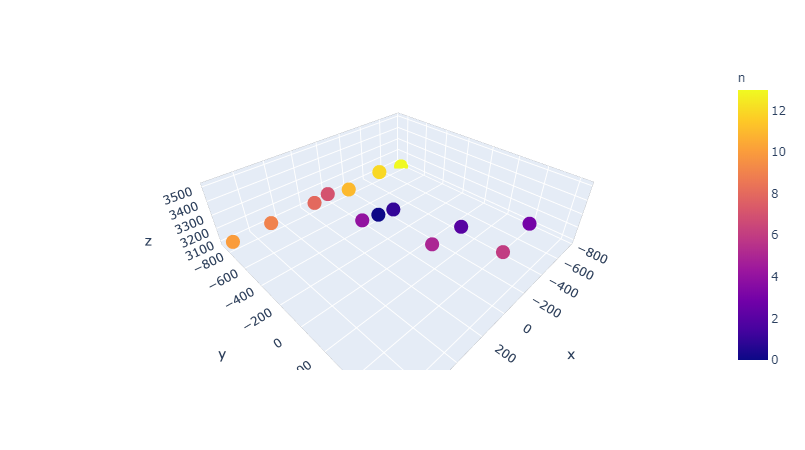

In [24]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(df, x='x', y='y', z='z', color='n')
fig.show()

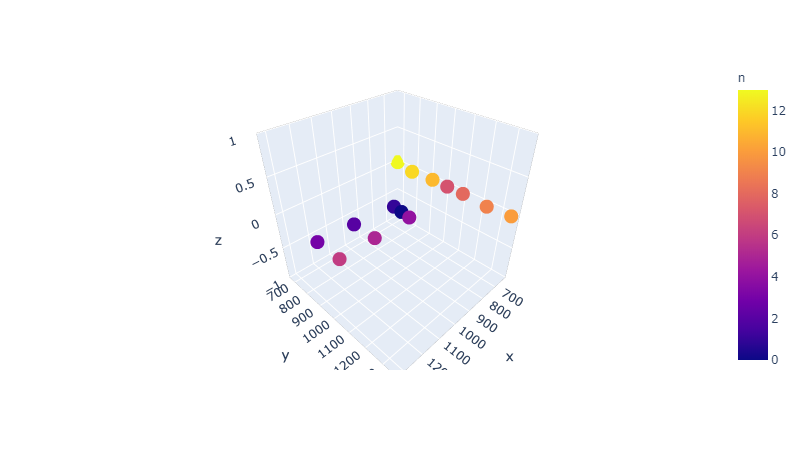

In [25]:
x = test_set.poses2d[i,CocoExJoints.TO_COMMON14, 0]
y = test_set.poses2d[i,CocoExJoints.TO_COMMON14, 1]
n = range(len(x))
# z = test_set.poses2d[i,:, 2]

df = pd.DataFrame({'x': y, 'y': x, 'z':np.zeros_like(x), 'n':n}) #, 'z': z
fig = px.scatter_3d(df, x='x', y='y', z='z', color='n')
fig.show()